In [1]:
import pandas as pd
import numpy as np
import pickle
import torch  # Need this to unpickle torch tensors
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost.callback import EarlyStopping

print("XGBoost version:", xgb.__version__)
print("PyTorch version:", torch.__version__)

XGBoost version: 3.1.1
PyTorch version: 2.9.1+cpu


In [2]:
# Cell 2

# Load the training data
print("Loading training data...")
with open('../../../data/train/combined_train_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert to DataFrame if needed
if not isinstance(data, pd.DataFrame):
    df = pd.DataFrame(data)
else:
    df = data

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nScore statistics:")
print(df['score'].describe())

Loading training data...
Dataset shape: (175272, 11)
Columns: ['accession', 'scoreset', 'ensp', 'pos', 'ref_long', 'alt_long', 'score', 'ref_embedding', 'alt_embedding', 'biotype', 'consequences']

Score statistics:
count    175272.000000
mean          0.753209
std           4.659253
min         -47.926820
25%          -0.348402
50%          -0.028166
75%           0.633806
max         179.315403
Name: score, dtype: float64


In [3]:
# # Cell 3

# # Extract features from embeddings
# print("Preparing features...")

# # Create feature matrix
# X_list = []
# y_list = []

# for idx in tqdm(range(len(df)), desc="Processing embeddings"):
#     row = df.iloc[idx]
    
#     ref_emb = np.array(row['ref_embedding'])
#     alt_emb = np.array(row['alt_embedding'])
    
#     # Check for NaN/Inf
#     if np.isnan(ref_emb).any() or np.isinf(ref_emb).any():
#         continue
#     if np.isnan(alt_emb).any() or np.isinf(alt_emb).any():
#         continue
    
#     # Create features: difference and absolute difference
#     diff = alt_emb - ref_emb
#     abs_diff = np.abs(diff)
    
#     # Concatenate features
#     features = np.concatenate([diff, abs_diff])
    
#     X_list.append(features)
#     y_list.append(row['score'])

# X = np.array(X_list)
# y = np.array(y_list)

# print(f"\nFeature matrix shape: {X.shape}")
# print(f"Target vector shape: {y.shape}")
# print(f"Removed {len(df) - len(X)} corrupted samples")

# Cell 3

# Extract features from embeddings + other columns
print("Preparing features...")

# Categorical columns (will be encoded as integers)
cat_columns = ['accession', 'scoreset', 'ensp', 'ref_long', 'alt_long', 'biotype']

# Build mapping dicts from training data
cat_maps = {}
for col in cat_columns:
    # Ensure string type for consistent mapping
    df[col] = df[col].astype(str)
    uniques = df[col].dropna().unique()
    cat_maps[col] = {val: idx for idx, val in enumerate(uniques)}
    print(f"Column '{col}' -> {len(uniques)} unique categories")

# Create feature matrix
X_list = []
y_list = []

for idx in tqdm(range(len(df)), desc="Processing embeddings"):
    row = df.iloc[idx]
    
    # Embeddings
    ref_emb = np.array(row['ref_embedding'])
    alt_emb = np.array(row['alt_embedding'])
    
    # Check for NaN/Inf in embeddings
    if np.isnan(ref_emb).any() or np.isinf(ref_emb).any():
        continue
    if np.isnan(alt_emb).any() or np.isinf(alt_emb).any():
        continue
    
    # Embedding-based features: difference and absolute difference
    diff = alt_emb - ref_emb
    abs_diff = np.abs(diff)
    
    # Categorical features (encoded using training mappings)
    cat_feats = []
    for col in cat_columns:
        val = str(row[col])
        # Use -1 for unseen / missing values
        cat_feats.append(cat_maps[col].get(val, -1))
    
    # Numeric feature: position
    pos_val = row['pos']
    if pd.isna(pos_val) or np.isinf(pos_val):
        # Skip rows with invalid position
        continue
    
    extra_features = np.array(cat_feats + [pos_val], dtype=np.float32)
    
    # Concatenate everything into a single feature vector
    features = np.concatenate([diff, abs_diff, extra_features])
    
    X_list.append(features)
    y_list.append(row['score'])

X = np.array(X_list)
y = np.array(y_list)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Removed {len(df) - len(X)} corrupted samples")


Preparing features...
Column 'accession' -> 175272 unique categories
Column 'scoreset' -> 200 unique categories
Column 'ensp' -> 136 unique categories
Column 'ref_long' -> 20 unique categories
Column 'alt_long' -> 21 unique categories
Column 'biotype' -> 5 unique categories


Processing embeddings:   0%|          | 0/175272 [00:00<?, ?it/s]C:\Users\brady\AppData\Local\Temp\ipykernel_26284\3986117806.py:64: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ref_emb = np.array(row['ref_embedding'])
C:\Users\brady\AppData\Local\Temp\ipykernel_26284\3986117806.py:65: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  alt_emb = np.array(row['alt_embedding'])
Processing embeddings: 100%|██████████| 175272/175272 [00:10<00:00, 16711.98it/s]



Feature matrix shape: (175270, 2311)
Target vector shape: (175270,)
Removed 2 corrupted samples


In [4]:
# Cell 4

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set: 140216 samples
Validation set: 35054 samples


In [5]:
# Cell 5

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

print("Training XGBoost model...")
print(f"Parameters: {params}\n")

# Create and train model
model = xgb.XGBRegressor(**params)

# Train with evaluation set for early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

print("\nTraining completed!")
# print(f"Best iteration: {model.best_iteration}")
print(f"Best score: {model.best_score:.4f}")

Training XGBoost model...
Parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'random_state': 42, 'n_jobs': -1}

[0]	validation_0-rmse:4.28455	validation_1-rmse:4.46409
[1]	validation_0-rmse:3.94901	validation_1-rmse:4.13338
[2]	validation_0-rmse:3.68179	validation_1-rmse:3.86038
[3]	validation_0-rmse:3.40458	validation_1-rmse:3.60939
[4]	validation_0-rmse:3.19603	validation_1-rmse:3.41332
[5]	validation_0-rmse:3.00279	validation_1-rmse:3.24360
[6]	validation_0-rmse:2.84809	validation_1-rmse:3.10863
[7]	validation_0-rmse:2.69854	validation_1-rmse:2.96969
[8]	validation_0-rmse:2.58739	validation_1-rmse:2.87444
[9]	validation_0-rmse:2.46186	validation_1-rmse:2.77796
[10]	validation_0-rmse:2.36879	validation_1-rmse:2.71015
[11]	validation_0-rmse:2.32646	validation_1-rmse:2.68956
[12]	validation_0-rmse:2.23955	validation_1

AttributeError: `best_score` is only defined when early stopping is used.

In [6]:
# Cell 6

# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("=" * 60)
print("TRAINING SET RESULTS")
print("=" * 60)
print(f"MSE:  {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE:  {train_mae:.4f}")
print(f"R²:   {train_r2:.4f}")

print("\n" + "=" * 60)
print("VALIDATION SET RESULTS")
print("=" * 60)
print(f"MSE:  {val_mse:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"MAE:  {val_mae:.4f}")
print(f"R²:   {val_r2:.4f}")

print("\n" + "=" * 60)
print("COMPARISON TO BASELINE")
print("=" * 60)
print(f"Baseline MSE:        8.5000")
print(f"XGBoost MSE:         {val_mse:.4f}")
if val_mse < 8.5:
    improvement = ((8.5 - val_mse) / 8.5) * 100
    print(f"Improvement:         {improvement:.1f}% better! 🎉")
else:
    worse = ((val_mse - 8.5) / 8.5) * 100
    print(f"Performance:         {worse:.1f}% worse")
print("=" * 60)

TRAINING SET RESULTS
MSE:  0.4139
RMSE: 0.6433
MAE:  0.3207
R²:   0.9806

VALIDATION SET RESULTS
MSE:  5.1437
RMSE: 2.2680
MAE:  0.4857
R²:   0.7768

COMPARISON TO BASELINE
Baseline MSE:        8.5000
XGBoost MSE:         5.1437
Improvement:         39.5% better! 🎉


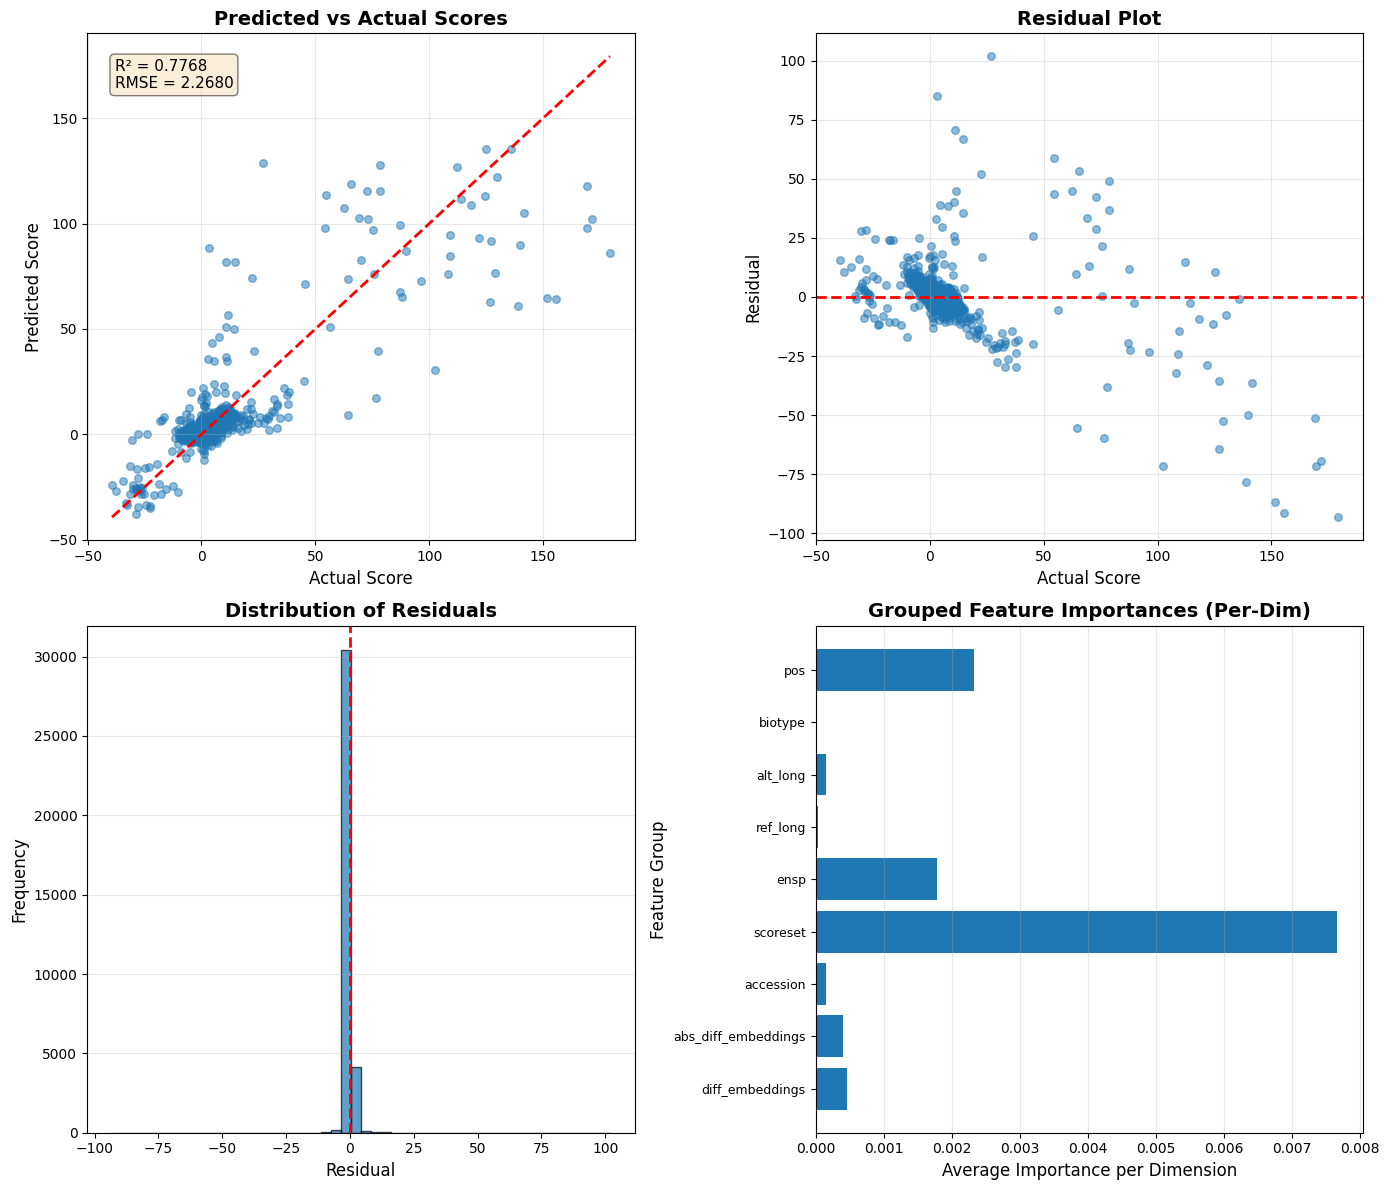

Visualization saved as 'xgboost_results.png'


In [11]:
# Cell 7

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Predicted vs Actual
ax1 = axes[0, 0]
ax1.scatter(y_val, y_val_pred, alpha=0.5, s=30)
ax1.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Score', fontsize=12)
ax1.set_ylabel('Predicted Score', fontsize=12)
ax1.set_title('Predicted vs Actual Scores', fontsize=14, fontweight='bold')
ax1.text(0.05, 0.95, f'R² = {val_r2:.4f}\nRMSE = {val_rmse:.4f}', 
         transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax1.grid(True, alpha=0.3)

# 2. Residuals
ax2 = axes[0, 1]
residuals = y_val_pred - y_val
ax2.scatter(y_val, residuals, alpha=0.5, s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Actual Score', fontsize=12)
ax2.set_ylabel('Residual', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Residual distribution
ax3 = axes[1, 0]
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Residual', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')


# 4. Feature importance (top 20)
# ax4 = axes[1, 1]

# # --- build feature names in the SAME order as X ---
# # X has shape (n_samples, 2*embedding_dim + len(cat_columns) + 1)
# n_total_features = X.shape[1]
# n_cat_plus_pos = len(cat_columns) + 1
# n_emb_features = n_total_features - n_cat_plus_pos
# embedding_dim = n_emb_features // 2  # because we used diff + abs_diff

# feature_names = (
#     [f"diff_{i}" for i in range(embedding_dim)] +
#     [f"|diff|_{i}" for i in range(embedding_dim)] +
#     cat_columns +
#     ["pos"]
# )

# # --- plot top 20 with names ---
# importance = model.feature_importances_
# top_features = np.argsort(importance)[-20:]

# ax4.barh(range(len(top_features)), importance[top_features])
# ax4.set_yticks(range(len(top_features)))
# ax4.set_yticklabels([feature_names[i] for i in top_features], fontsize=8)

# ax4.set_xlabel('Importance', fontsize=12)
# ax4.set_ylabel('Feature', fontsize=12)
# ax4.set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
# ax4.grid(True, alpha=0.3, axis='x')

# # 4. Feature importance (grouped: embeddings vs other features)
# ax4 = axes[1, 1]

# importance = model.feature_importances_

# # --- figure out layout of features in X ---
# # X was built as: [diff (D), abs_diff (D), extra_features (cat + pos)]
# n_total_features = X.shape[1]
# n_cat_plus_pos = len(cat_columns) + 1  # +1 for 'pos'
# n_emb_features = n_total_features - n_cat_plus_pos
# embedding_dim = n_emb_features // 2    # because diff + abs_diff

# # Sanity check (optional)
# assert 2 * embedding_dim + n_cat_plus_pos == n_total_features, "Feature layout mismatch"

# # --- define groups ---
# group_names = ['diff_embeddings', 'abs_diff_embeddings'] + cat_columns + ['pos']
# group_importances = []

# idx = 0

# # 1) diff embeddings block
# group_importances.append(importance[idx : idx + embedding_dim].sum())
# idx += embedding_dim

# # 2) |diff| embeddings block
# group_importances.append(importance[idx : idx + embedding_dim].sum())
# idx += embedding_dim

# # 3) each extra feature gets its own group
# for _ in cat_columns + ['pos']:
#     group_importances.append(importance[idx])
#     idx += 1

# # --- plot grouped importances ---
# y_pos = np.arange(len(group_names))
# ax4.barh(y_pos, group_importances)
# ax4.set_yticks(y_pos)
# ax4.set_yticklabels(group_names, fontsize=9)

# ax4.set_xlabel('Grouped Importance', fontsize=12)
# ax4.set_ylabel('Feature Group', fontsize=12)
# ax4.set_title('Grouped Feature Importances', fontsize=14, fontweight='bold')
# ax4.grid(True, alpha=0.3, axis='x')

# 4. Feature importance (grouped, average per dimension)
ax4 = axes[1, 1]

importance = model.feature_importances_

n_total_features = X.shape[1]
n_cat_plus_pos = len(cat_columns) + 1
n_emb_features = n_total_features - n_cat_plus_pos
embedding_dim = n_emb_features // 2

assert 2 * embedding_dim + n_cat_plus_pos == n_total_features

group_names = ['diff_embeddings', 'abs_diff_embeddings'] + cat_columns + ['pos']
group_importances = []

idx = 0

# diff embeddings: mean importance per embedding dimension
diff_block = importance[idx : idx + embedding_dim]
group_importances.append(diff_block.mean())
idx += embedding_dim

# abs_diff embeddings: mean importance per embedding dimension
abs_block = importance[idx : idx + embedding_dim]
group_importances.append(abs_block.mean())
idx += embedding_dim

# scalar features: each is already 1-d, so mean == value
for _ in cat_columns + ['pos']:
    group_importances.append(importance[idx])
    idx += 1

y_pos = np.arange(len(group_names))
ax4.barh(y_pos, group_importances)
ax4.set_yticks(y_pos)
ax4.set_yticklabels(group_names, fontsize=9)

ax4.set_xlabel('Average Importance per Dimension', fontsize=12)
ax4.set_ylabel('Feature Group', fontsize=12)
ax4.set_title('Grouped Feature Importances (Per-Dim)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')


plt.tight_layout()
plt.savefig('xgboost_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'xgboost_results.png'")

In [8]:
# # Cell 8

# # Load test data
# print("Loading test data...")
# with open('../../../data/test/combined_test_data.pkl', 'rb') as f:
#     test_data = pickle.load(f)

# if not isinstance(test_data, pd.DataFrame):
#     test_df = pd.DataFrame(test_data)
# else:
#     test_df = test_data

# print(f"Test dataset shape: {test_df.shape}")

# # Prepare test features
# print("Preparing test features...")
# X_test_list = []
# accessions = []

# for idx in tqdm(range(len(test_df)), desc="Processing test data"):
#     row = test_df.iloc[idx]
    
#     ref_emb = np.array(row['ref_embedding'])
#     alt_emb = np.array(row['alt_embedding'])
    
#     # Check for NaN/Inf
#     if np.isnan(ref_emb).any() or np.isinf(ref_emb).any():
#         # Use zeros for corrupted embeddings
#         ref_emb = np.zeros_like(ref_emb)
#     if np.isnan(alt_emb).any() or np.isinf(alt_emb).any():
#         alt_emb = np.zeros_like(alt_emb)
    
#     # Create features
#     diff = alt_emb - ref_emb
#     abs_diff = np.abs(diff)
#     features = np.concatenate([diff, abs_diff])
    
#     X_test_list.append(features)
#     accessions.append(row['accession'])

# X_test = np.array(X_test_list)

# print(f"Test feature matrix shape: {X_test.shape}")

# # Generate predictions
# print("Generating predictions...")
# test_predictions = model.predict(X_test)

# # Create submission file
# submission_df = pd.DataFrame({
#     'accession': accessions,
#     'score': test_predictions
# })

# # Save to CSV
# output_path = './output_XG.csv'
# submission_df.to_csv(output_path, index=False)

# print(f"\n✓ Predictions saved to {output_path}")
# print(f"\nSubmission file preview:")
# print(submission_df.head(10))
# print(f"\nPrediction statistics:")
# print(f"Min:    {test_predictions.min():.4f}")
# print(f"Max:    {test_predictions.max():.4f}")
# print(f"Mean:   {test_predictions.mean():.4f}")
# print(f"Median: {np.median(test_predictions):.4f}")
# print(f"Std:    {test_predictions.std():.4f}")

# Cell 8

# Load test data
print("Loading test data...")
with open('../../../data/test/combined_test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

if not isinstance(test_data, pd.DataFrame):
    test_df = pd.DataFrame(test_data)
else:
    test_df = test_data

print(f"Test dataset shape: {test_df.shape}")

# Make sure categorical columns are strings
for col in cat_columns:
    test_df[col] = test_df[col].astype(str)

# Prepare test features
print("Preparing test features...")
X_test_list = []
accessions = []

for idx in tqdm(range(len(test_df)), desc="Processing test data"):
    row = test_df.iloc[idx]
    
    # Embeddings
    ref_emb = np.array(row['ref_embedding'])
    alt_emb = np.array(row['alt_embedding'])
    
    # Handle NaN/Inf in embeddings by replacing with zeros
    if np.isnan(ref_emb).any() or np.isinf(ref_emb).any():
        ref_emb = np.zeros_like(ref_emb)
    if np.isnan(alt_emb).any() or np.isinf(alt_emb).any():
        alt_emb = np.zeros_like(alt_emb)
    
    # Embedding-based features
    diff = alt_emb - ref_emb
    abs_diff = np.abs(diff)
    
    # Categorical features using *training* mappings
    cat_feats = []
    for col in cat_columns:
        val = str(row[col])
        cat_feats.append(cat_maps[col].get(val, -1))  # -1 for unseen
    
    # Numeric feature: position
    pos_val = row['pos']
    if pd.isna(pos_val) or np.isinf(pos_val):
        pos_val = -1  # fallback value for invalid positions
    
    extra_features = np.array(cat_feats + [pos_val], dtype=np.float32)
    
    # Concatenate all features
    features = np.concatenate([diff, abs_diff, extra_features])
    
    X_test_list.append(features)
    accessions.append(row['accession'])

X_test = np.array(X_test_list)

print(f"Test feature matrix shape: {X_test.shape}")

# Generate predictions
print("Generating predictions...")
test_predictions = model.predict(X_test)

# Create submission file
submission_df = pd.DataFrame({
    'accession': accessions,
    'score': test_predictions
})

# Save to CSV
output_path = './output_XG.csv'
submission_df.to_csv(output_path, index=False)

print(f"\n✓ Predictions saved to {output_path}")
print(f"\nSubmission file preview:")
print(submission_df.head(10))
print(f"\nPrediction statistics:")
print(f"Min:    {test_predictions.min():.4f}")
print(f"Max:    {test_predictions.max():.4f}")
print(f"Mean:   {test_predictions.mean():.4f}")
print(f"Median: {np.median(test_predictions):.4f}")
print(f"Std:    {test_predictions.std():.4f}")


Loading test data...
Test dataset shape: (118421, 10)
Preparing test features...


Processing test data:   0%|          | 0/118421 [00:00<?, ?it/s]C:\Users\brady\AppData\Local\Temp\ipykernel_26284\826935804.py:96: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ref_emb = np.array(row['ref_embedding'])
C:\Users\brady\AppData\Local\Temp\ipykernel_26284\826935804.py:97: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  alt_emb = np.array(row['alt_embedding'])
Processing test data: 100%|██████████| 118421/118421 [00:07<00:00, 15586.73it/s]


Test feature matrix shape: (118421, 2311)
Generating predictions...

✓ Predictions saved to ./output_XG.csv

Submission file preview:
                    accession     score
0   urn:mavedb:00000069-a-2#1 -2.306211
1   urn:mavedb:00000069-a-2#2 -2.231262
2   urn:mavedb:00000069-a-2#3 -2.496899
3   urn:mavedb:00000069-a-2#4 -2.894432
4   urn:mavedb:00000069-a-2#5 -2.819334
5   urn:mavedb:00000069-a-2#6 -2.912751
6   urn:mavedb:00000069-a-2#7 -3.432726
7   urn:mavedb:00000069-a-2#8 -2.983812
8   urn:mavedb:00000069-a-2#9 -3.216486
9  urn:mavedb:00000069-a-2#10 -3.165829

Prediction statistics:
Min:    -34.1906
Max:    128.9951
Mean:   0.9346
Median: 0.3199
Std:    3.8777
